# CycleGAN Implementation for Person Face Sketches

# Libaraies

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from glob import glob
import itertools

# Parameters 

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
random.seed(42)

# Define hyperparameters
BATCH_SIZE = 4
IMG_SIZE = 256
EPOCHS = 50
LR = 0.0002
BETA1 = 0.5
LAMBDA_CYCLE = 10.0
LAMBDA_IDENTITY = 0.5
NUM_IMAGES = 2500

# Define the dataset paths
train_a = glob('/kaggle/input/person-face-sketches/train/photos/*')[:NUM_IMAGES]
train_b = glob('/kaggle/input/person-face-sketches/train/sketches/*')[:NUM_IMAGES]

# FaceSketchDataset

In [3]:
# Custom Dataset
class FaceSketchDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(self.image_paths[index]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

    def __len__(self):
        return len(self.image_paths)

# Data transforms
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create datasets and dataloaders
dataset_a = FaceSketchDataset(train_a, transform)
dataset_b = FaceSketchDataset(train_b, transform)
dataloader_a = DataLoader(dataset_a, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
dataloader_b = DataLoader(dataset_b, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# Generator architecture

In [4]:

# Generator architecture
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_channels, output_channels, num_residual_blocks=9):
        super(Generator, self).__init__()
        
        # Initial convolution block
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_channels, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]
        
        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2

        # Output layer
        model += [nn.ReflectionPad2d(3),
                  nn.Conv2d(64, output_channels, 7),
                  nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

# Discriminator

In [5]:
# Discriminator architecture
class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(input_channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, x):
        return self.model(x)

# Initialize models,  Loss functions, Optimizers

In [6]:
# Initialize models
G_AB = Generator(3, 3).cuda()
G_BA = Generator(3, 3).cuda()
D_A = Discriminator(3).cuda()
D_B = Discriminator(3).cuda()

# Loss functions
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# Optimizers
optimizer_G = optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=LR, betas=(BETA1, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=LR, betas=(BETA1, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=LR, betas=(BETA1, 0.999))

# Training function

In [7]:
# Training function
def train(epoch):
    G_AB.train()
    G_BA.train()
    D_A.train()
    D_B.train()

    for i, (real_A, real_B) in enumerate(zip(dataloader_a, dataloader_b)):
        real_A = real_A.cuda()
        real_B = real_B.cuda()

        # Generate fake images
        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)

        # Train Generators
        optimizer_G.zero_grad()

        # Identity loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)
        loss_identity = (loss_id_A + loss_id_B) * LAMBDA_IDENTITY

        # GAN loss
        loss_GAN_AB = criterion_GAN(D_B(fake_B), torch.ones_like(D_B(fake_B)))
        loss_GAN_BA = criterion_GAN(D_A(fake_A), torch.ones_like(D_A(fake_A)))
        loss_GAN = loss_GAN_AB + loss_GAN_BA

        # Cycle loss
        recov_A = G_BA(fake_B)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) * LAMBDA_CYCLE

        # Total generator loss
        loss_G = loss_GAN + loss_cycle + loss_identity
        loss_G.backward()
        optimizer_G.step()

        # Train Discriminator A
        optimizer_D_A.zero_grad()
        loss_real = criterion_GAN(D_A(real_A), torch.ones_like(D_A(real_A)))
        loss_fake = criterion_GAN(D_A(fake_A.detach()), torch.zeros_like(D_A(fake_A)))
        loss_D_A = (loss_real + loss_fake) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        # Train Discriminator B
        optimizer_D_B.zero_grad()
        loss_real = criterion_GAN(D_B(real_B), torch.ones_like(D_B(real_B)))
        loss_fake = criterion_GAN(D_B(fake_B.detach()), torch.zeros_like(D_B(fake_B)))
        loss_D_B = (loss_real + loss_fake) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{EPOCHS}] Batch [{i}/{len(dataloader_a)}] "
                  f"Loss D: {(loss_D_A + loss_D_B).item():.4f} "
                  f"Loss G: {loss_G.item():.4f} "
                  f"Loss Cycle: {loss_cycle.item():.4f} "
                  f"Loss Identity: {loss_identity.item():.4f}")

# Training loop

In [8]:
# Training loop
for epoch in range(EPOCHS):
    train(epoch)
    
    # Save models
    if (epoch + 1) % 10 == 0:
        torch.save(G_AB.state_dict(), f'G_AB_epoch_{epoch+1}.pth')
        torch.save(G_BA.state_dict(), f'G_BA_epoch_{epoch+1}.pth')
        torch.save(D_A.state_dict(), f'D_A_epoch_{epoch+1}.pth')
        torch.save(D_B.state_dict(), f'D_B_epoch_{epoch+1}.pth')



Epoch [0/50] Batch [0/500] Loss D: 1.2507 Loss G: 17.7336 Loss Cycle: 14.8498 Loss Identity: 0.7433
Epoch [0/50] Batch [100/500] Loss D: 0.4278 Loss G: 3.5488 Loss Cycle: 2.7749 Loss Identity: 0.1532
Epoch [0/50] Batch [200/500] Loss D: 0.3975 Loss G: 3.6325 Loss Cycle: 2.6200 Loss Identity: 0.1595
Epoch [0/50] Batch [300/500] Loss D: 0.4153 Loss G: 2.8275 Loss Cycle: 2.3001 Loss Identity: 0.1316
Epoch [0/50] Batch [400/500] Loss D: 0.3223 Loss G: 3.3629 Loss Cycle: 2.3447 Loss Identity: 0.1176
Epoch [1/50] Batch [0/500] Loss D: 0.3492 Loss G: 3.2311 Loss Cycle: 2.1866 Loss Identity: 0.1240
Epoch [1/50] Batch [100/500] Loss D: 0.3639 Loss G: 2.8491 Loss Cycle: 2.0348 Loss Identity: 0.1278
Epoch [1/50] Batch [200/500] Loss D: 0.4000 Loss G: 2.9150 Loss Cycle: 2.1258 Loss Identity: 0.1451
Epoch [1/50] Batch [300/500] Loss D: 0.3264 Loss G: 3.0020 Loss Cycle: 2.0811 Loss Identity: 0.1290
Epoch [1/50] Batch [400/500] Loss D: 0.2910 Loss G: 3.1032 Loss Cycle: 2.0482 Loss Identity: 0.1303
Ep


KeyboardInterrupt



# generate_images

In [9]:
# Test function
def generate_images(G_AB, G_BA, test_A, test_B):
    G_AB.eval()
    G_BA.eval()
    with torch.no_grad():
        fake_B = G_AB(test_A)
        fake_A = G_BA(test_B)
    return fake_A, fake_B

# Load and preprocess test images
test_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [57]:
test_A = Image.open('/kaggle/input/person-face-sketches/test/photos/10132.jpg').convert('RGB')
test_B = Image.open('/kaggle/input/person-face-sketches/test/sketches/10132.jpg').convert('RGB')


test_A = test_transform(test_A).unsqueeze(0).cuda()
test_B = test_transform(test_B).unsqueeze(0).cuda()

# Generate images
fake_A, fake_B = generate_images(G_AB, G_BA, test_A, test_B)

# ensors to images and display

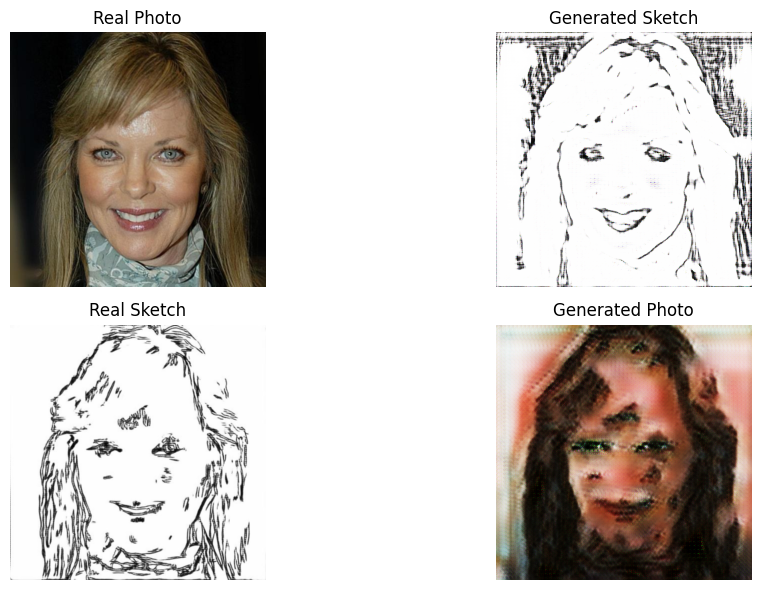

In [58]:
import matplotlib.pyplot as plt
# Convert tensors to images and display
def tensor_to_image(tensor):
    image = tensor.cpu().squeeze().permute(1, 2, 0).detach().numpy()
    image = (image + 1) / 2.0 * 255
    return image.astype('uint8')

plt.figure(figsize=(12, 6))
plt.subplot(221)
plt.imshow(tensor_to_image(test_A))
plt.title('Real Photo')
plt.axis('off')

plt.subplot(222)
plt.imshow(tensor_to_image(fake_B))
plt.title('Generated Sketch')
plt.axis('off')

plt.subplot(223)
plt.imshow(tensor_to_image(test_B))
plt.title('Real Sketch')
plt.axis('off')

plt.subplot(224)
plt.imshow(tensor_to_image(fake_A))
plt.title('Generated Photo')
plt.axis('off')

plt.tight_layout()
plt.show()

In [46]:
for s in train_a:
    print(s)

/kaggle/input/person-face-sketches/train/photos/19812.jpg
/kaggle/input/person-face-sketches/train/photos/22735.jpg
/kaggle/input/person-face-sketches/train/photos/16916.jpg
/kaggle/input/person-face-sketches/train/photos/22706.jpg
/kaggle/input/person-face-sketches/train/photos/12666.jpg
/kaggle/input/person-face-sketches/train/photos/13288.jpg
/kaggle/input/person-face-sketches/train/photos/20088.jpg
/kaggle/input/person-face-sketches/train/photos/28578.jpg
/kaggle/input/person-face-sketches/train/photos/22288.jpg
/kaggle/input/person-face-sketches/train/photos/24819.jpg
/kaggle/input/person-face-sketches/train/photos/6241.jpg
/kaggle/input/person-face-sketches/train/photos/25540.jpg
/kaggle/input/person-face-sketches/train/photos/20529.jpg
/kaggle/input/person-face-sketches/train/photos/27582.jpg
/kaggle/input/person-face-sketches/train/photos/623.jpg
/kaggle/input/person-face-sketches/train/photos/2193.jpg
/kaggle/input/person-face-sketches/train/photos/14143.jpg
/kaggle/input/pers